# Fetal Health Classification — Improved Preprocessing & Class-Sensitive Optimization

**Goal:** Improve detection (high recall) of **class 2 (Suspect)** and especially **class 3 (Pathological)** by using advanced preprocessing, SMOTE oversampling, and model weighting/tuning.

**What this notebook does:**
- Loads the `fetal_health.csv` dataset (Kaggle fallback available)
- EDA and class imbalance check
- Outlier removal (IQR), skewness check, and per-feature transform selection (log1p, sqrt, or Yeo–Johnson)
- Feature scaling (StandardScaler)
- SMOTE oversampling on the training set
- Train multiple models with class-weighting and evaluate with emphasis on recall for classes 2 & 3
- Hyperparameter tuning of LightGBM maximizing recall for class 3

**Output:** A model comparison table with metrics, confusion matrices, and downloadable artifacts (summary CSV, selected features).


In [1]:
try:
    import imblearn
except Exception:
    pass

import os, warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import xgboost as xgb
import lightgbm as lgb

from imblearn.over_sampling import SMOTE

print('Environment ready')


Environment ready


In [2]:
# csv_path = './Dataset/fetal_health.csv'
# if not os.path.exists(csv_path):
#     try:
#         from kaggle.api.kaggle_api_extended import KaggleApi
#         api = KaggleApi()
#         api.authenticate()
#         api.dataset_download_file('andrewmvd/fetal-health-classification', 'fetal_health.csv', path='.', unzip=True)
#         print('Downloaded fetal_health.csv via Kaggle API')
#     except Exception as e:
#         print('Kaggle download failed or not configured:', e)
#         print('Please place fetal_health.csv in the notebook directory and re-run')

df = pd.read_csv('./Dataset/fetal_health.csv')
print('Loaded dataset shape:', df.shape)
df.head()


Loaded dataset shape: (2126, 22)


,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variabi

None


Missing values:
baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode         

fetal_health
1.0    1655
2.0     295
3.0     176
Name: count, dtype: int64

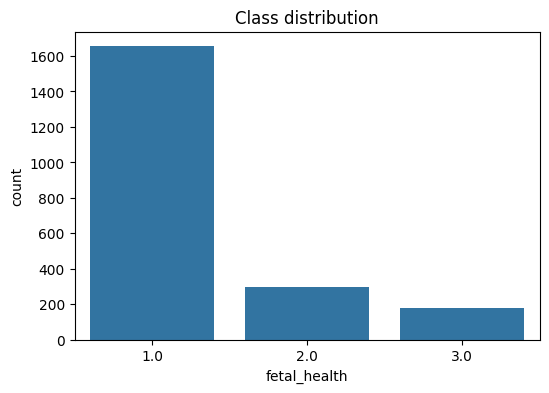

In [3]:
print('Info:')
display(df.info())
print('\nMissing values:')
print(df.isnull().sum())
print('\nDuplicates:', df.duplicated().sum())
print('\nClass distribution:')
display(df['fetal_health'].value_counts())
plt.figure(figsize=(6,4))
sns.countplot(x='fetal_health', data=df)
plt.title('Class distribution')
plt.show()


In [4]:
# 1) Drop duplicates
df = df.drop_duplicates().reset_index(drop=True)
print('After drop_duplicates shape:', df.shape)

# 2) Separate X/y
X = df.drop(columns=['fetal_health']).copy()
y = df['fetal_health'].copy()

# 3) Cap outliers using IQR per feature (clip)
X_capped = X.copy()
for col in X.columns:
    q1 = X[col].quantile(0.25)
    q3 = X[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    X_capped[col] = X[col].clip(lower, upper)
print('Capped outliers with IQR method')

# 4) Skewness check
skewness = X_capped.skew().abs().sort_values(ascending=False)
print('Top skewed features:')
display(skewness.head(15))

# 5) Choose transforms for features with abs(skew) > 0.75
pt = PowerTransformer(method='yeo-johnson', standardize=False)
X_trans = X_capped.copy()
applied = {}
for col in X_capped.columns:
    sk = X_capped[col].skew()
    if abs(sk) > 0.75:
        if (X_capped[col] > 0).all():
            log_sk = np.abs(np.log1p(X_capped[col]).skew())
            sqrt_sk = np.abs(np.sqrt(X_capped[col]).skew())
            if log_sk < sqrt_sk:
                X_trans[col] = np.log1p(X_capped[col])
                applied[col] = 'log1p'
            else:
                X_trans[col] = np.sqrt(X_capped[col])
                applied[col] = 'sqrt'
        else:
            X_trans[col] = pt.fit_transform(X_capped[[col]]).flatten()
            applied[col] = 'yeo-johnson'
    else:
        applied[col] = 'none'
print('Applied transforms (showing ones applied):')
display({k:v for k,v in applied.items() if v!='none'})

# 6) Feature selection via SelectKBest
k = 12
selector = SelectKBest(score_func=f_classif, k=k)
selector.fit(X_trans, y)
cols = selector.get_support(indices=True)
selected_features = X_trans.columns[cols].tolist()
print('Selected features:', selected_features)

# 7) Train/test split
X_selected = X_trans[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.30, random_state=42, stratify=y)
print('Train / Test shapes:', X_train.shape, X_test.shape)


After drop_duplicates shape: (2113, 22)
Capped outliers with IQR method
Top skewed features:


fetal_movement                                            1.319638
percentage_of_time_with_abnormal_long_term_variability    1.251984
histogram_variance                                        1.232060
light_decelerations                                       1.197696
accelerations                                             1.140790
mean_value_of_short_term_variability                      0.787788
histogram_number_of_peaks                                 0.766925
mean_value_of_long_term_variability                       0.527798
histogram_mean                                            0.434415
histogram_mode                                            0.337599
histogram_max                                             0.332501
histogram_median                                          0.322105
histogram_width                                           0.311019
histogram_tendency                                        0.309129
uterine_contractions                                      0.15

Applied transforms (showing ones applied):


{'accelerations': 'yeo-johnson',
 'fetal_movement': 'yeo-johnson',
 'light_decelerations': 'yeo-johnson',
 'mean_value_of_short_term_variability': 'log1p',
 'percentage_of_time_with_abnormal_long_term_variability': 'yeo-johnson',
 'histogram_number_of_peaks': 'yeo-johnson',
 'histogram_variance': 'yeo-johnson'}

Selected features: ['baseline value', 'accelerations', 'uterine_contractions', 'abnormal_short_term_variability', 'mean_value_of_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'mean_value_of_long_term_variability', 'histogram_min', 'histogram_mode', 'histogram_mean', 'histogram_median', 'histogram_variance']
Train / Test shapes: (1479, 12) (634, 12)


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('Scaling complete')

Scaling complete


In [6]:
print('Before SMOTE class counts:')
display(y_train.value_counts())

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

print('After SMOTE class counts:')
display(pd.Series(y_train_res).value_counts())

Before SMOTE class counts:


fetal_health
1.0    1152
2.0     204
3.0     123
Name: count, dtype: int64

After SMOTE class counts:


fetal_health
1.0    1152
3.0    1152
2.0    1152
Name: count, dtype: int64

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay

def evaluate_model(name, model, X_tr, X_te, y_tr, y_te):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    recalls = recall_score(y_te, y_pred, average=None, labels=[1,2,3])
    print(f'--- {name} ---')
    print('Accuracy:', acc)
    print(classification_report(y_te, y_pred, digits=4))
    print('Recall class 2 (Suspect):', recalls[1])
    print('Recall class 3 (Pathological):', recalls[2])
    cm = confusion_matrix(y_te, y_pred, labels=[1,2,3])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3])
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix - '+name)
    plt.show()
    return {'model': name, 'accuracy': acc, 'recall_2': recalls[1], 'recall_3': recalls[2]}


--- RandomForest (class_weight) ---
Accuracy: 0.9274447949526814
              precision    recall  f1-score   support

         1.0     0.9653    0.9575    0.9614       494
         2.0     0.7556    0.7727    0.7640        88
         3.0     0.8704    0.9038    0.8868        52

    accuracy                         0.9274       634
   macro avg     0.8637    0.8780    0.8707       634
weighted avg     0.9284    0.9274    0.9279       634

Recall class 2 (Suspect): 0.7727272727272727
Recall class 3 (Pathological): 0.9038461538461539


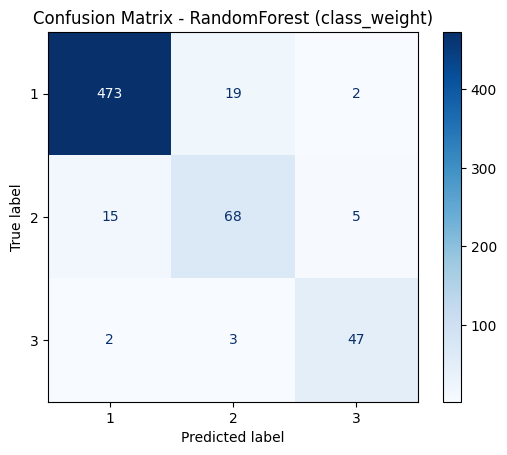

Class weight dict used for XGBoost (approx): {np.int64(1): np.float64(1.0), np.int64(2): np.float64(1.0), np.int64(3): np.float64(1.0)}

XGBoost classification report:
              precision    recall  f1-score   support

         1.0     0.9560    0.9676    0.9618       494
         2.0     0.7738    0.7386    0.7558        88
         3.0     0.8800    0.8462    0.8627        52

    accuracy                         0.9259       634
   macro avg     0.8699    0.8508    0.8601       634
weighted avg     0.9245    0.9259    0.9251       634



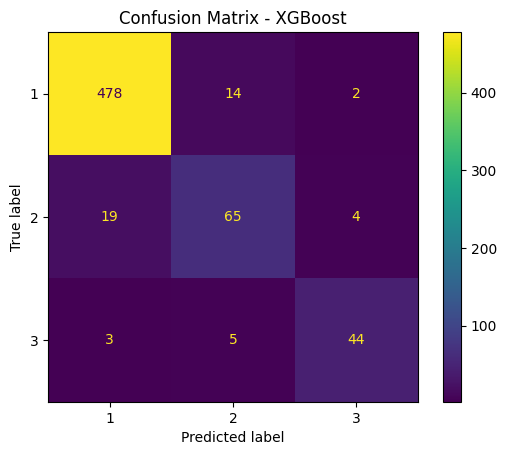

LightGBM class weight map: {1: 1.0, 2: 1.0, 3: 1.0}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3056
[LightGBM] [Info] Number of data points in the train set: 3456, number of used features: 12
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

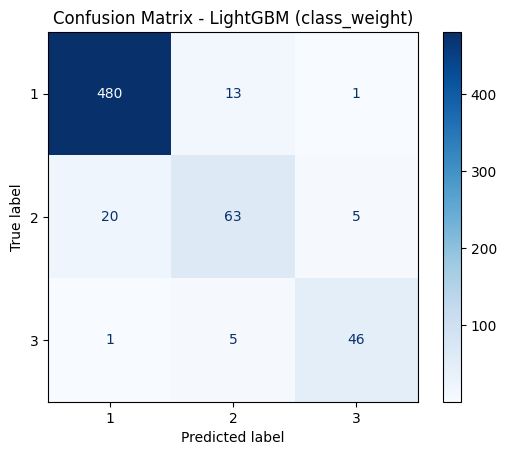

,model,accuracy,recall_2,recall_3
0,RandomForest (class_weight),0.927445,0.772727,0.903846
2,LightGBM (class_weight),0.929022,0.715909,0.884615
1,XGBoost,0.925868,0.738636,0.846154


In [9]:
# (re)build results list
results = []

# RandomForest with class_weight balanced
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
res_rf = evaluate_model('RandomForest (class_weight)', rf, X_train_res, X_test_scaled, y_train_res, y_test)
results.append(res_rf)

# XGBoost with sample weights derived from class weights
from sklearn.utils.class_weight import compute_class_weight

# compute balanced class weights on the original 1/2/3 labels
classes_orig = np.unique(y_train_res).astype(int)
cw = compute_class_weight(class_weight='balanced', classes=classes_orig, y=y_train_res.astype(int))
class_weight_dict = dict(zip(classes_orig, cw))
print('Class weight dict used for XGBoost (approx):', class_weight_dict)

# XGBoost's sklearn wrapper expects 0-based label indices for multiclass.
# Create 0-based training labels for XGBoost, keep original y_test for metrics.
y_train_res_xgb = y_train_res.astype(int) - 1

# sample weights mapped from the original class weights (works with original labels)
sample_weights = pd.Series(y_train_res.astype(int)).map(class_weight_dict).values

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train_res, y_train_res_xgb, sample_weight=sample_weights)

# predict (0-based) then convert back to original 1/2/3 labels for evaluation
y_pred_xgb = xgb_clf.predict(X_test_scaled)
y_pred_xgb_labels = (y_pred_xgb + 1).astype(int)

acc = accuracy_score(y_test, y_pred_xgb_labels)
recalls = recall_score(y_test, y_pred_xgb_labels, average=None, labels=[1,2,3])
res_xgb = {'model':'XGBoost','accuracy':acc,'recall_2':recalls[1],'recall_3':recalls[2]}

print('\nXGBoost classification report:')
print(classification_report(y_test, y_pred_xgb_labels, digits=4))
cm = confusion_matrix(y_test, y_pred_xgb_labels, labels=[1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[1,2,3]).plot()
plt.title('Confusion Matrix - XGBoost')
plt.show()
results.append(res_xgb)

# LightGBM with class_weight map
cw_all = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_res).astype(int), y=y_train_res.astype(int))
cw_map = {int(k): float(v) for k,v in zip(np.unique(y_train_res).astype(int), cw_all)}
print('LightGBM class weight map:', cw_map)
lgb_clf = lgb.LGBMClassifier(class_weight=cw_map, n_estimators=200, random_state=42)
res_lgb = evaluate_model('LightGBM (class_weight)', lgb_clf, X_train_res, X_test_scaled, y_train_res, y_test)
results.append(res_lgb)

# Summary
final_df = pd.DataFrame(results).sort_values(['recall_3','recall_2'], ascending=False)
display(final_df)


In [ ]:
from sklearn.model_selection import GridSearchCV

scorer = make_scorer(lambda y_true, y_pred: recall_score(y_true==3, y_pred==3))
param_grid = {
    'num_leaves': [31, 50],
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.01]
}

lgb_base = lgb.LGBMClassifier(class_weight=cw_map, random_state=42)
grid = GridSearchCV(lgb_base, param_grid, cv=3, scoring=scorer, n_jobs=-1, verbose=1)
print('Starting GridSearchCV optimizing recall for class 3...')
grid.fit(X_train_res, y_train_res)
print('Best params:', grid.best_params_)
best_lgb = grid.best_estimator_
res_best = evaluate_model('LightGBM (tuned for recall_3)', best_lgb, X_train_res, X_test_scaled, y_train_res, y_test)
display(res_best)


In [ ]:
# Save results and artifacts
final_df.to_csv('model_comparison_recalls.csv', index=False)
print('Saved model_comparison_recalls.csv')
with open('selected_features.txt','w') as f:
    f.write('\n'.join(selected_features))
print('Saved selected features to selected_features.txt')
print('Notebook ready — run it to execute preprocessing, SMOTE, training, and evaluation.')